# Phase 1: Data preparation & EDA

The focus for this preliminary part of the project is to acquire and prepare the dataset. I will be constructing the following pipeline:

![Main pipeline components](pipeline.png)

The flow of logic is essentially:

* __BOOKS__: Acquire each book, and make sure that we have just the text of the book (excluding Project Gutenberg information which is also found in the files but not required for our analysis)
* __CHAPTERS__: Split each book into its component chapters
* __PARAGRAPHS__: Split each chapter into paragraphs
* __SENTENCES__: Segment each paragraph into sentences
* __TOKENS (LEMMAS)__: Extract the tokens for each of the sentences as lemmas
* __SQL__: Store the processed data in a local sqlite3 database

This will position me to:

* Store the pre-processed information and retrieve it as needed, when working on the in-depth analyses in the second part of this project
* Access the book structures in any way that I need to: for example sampling from specific chapters; or retrieving individual chapters, paragraphs or sentences with required properties, for example all sentences that reference a specific character by name
* Retrieve pre-processed data in the 2 main formats that I will need: some nlp tasks use a bag-of-words type approach (tokens), where others require the full sentence for context
* Compile and store additional resources required for further analysis, such as vocabulary counts

The concept is a simple one: I can query the database directly for quick checks and aggregations, or I can read in results as a dataframe and continue working where I left off.

#### Library imports

In [1]:
# Standard utilities
import re
import pprint
import datetime
import itertools
import pandas as pd

# NLP tasks
import nltk
# Uncomment to run once at start if required
# nltk.download('punkt')
# nltk.download('punkt_tab')
from nltk.tokenize import word_tokenize
from nltk.tokenize import TreebankWordTokenizer
import spacy

# Storage
from sqlalchemy import create_engine

# Visualization
from matplotlib import pyplot as plt
import seaborn as sns
from matplotlib_venn import venn3, venn3_circles
from wordcloud import WordCloud

#### Settings

In [2]:
# Pandas settings
pd.set_option('display.max_colwidth', 500)

# Visualization settings
plt.rcParams["figure.figsize"] = (8, 6)
sns.set_theme()
author_colors = ['#ED230D', '#00A1FE','#1EB100', 'darkblue']

# SQL settings
%load_ext sql
%sql sqlite:///book_store.db
# Set the style to the old default as advised by
# https://stackoverflow.com/questions/79153112/keyerror-default-when-attempting-to-create-a-table-using-magic-line-sql-in-j
%config SqlMagic.style = '_DEPRECATED_DEFAULT'

engine = create_engine('sqlite:///book_store.db', echo=False)
connection = engine.raw_connection()

# Track time
processing_start = datetime.datetime.now()

## 1. Data acquisition

I've provided for loading the data from the local folder (the 4 novels' `*.txt` files can be downloaded from Project Gutenberg and placed in the same folder as this notebook); alternatively they can be downloaded direct from the Project Gutenberg website, using the method suggested in chapter 3 of '_Natural Language Processing with Python_' ([Bird, et al., 2009](https://www.nltk.org/book_1ed/ch03.html)).

Project Gutenberg books all use character set encoding: `utf-8`, but I used `utf-8-sig` for my encoding method because it removes an additional unwanted byte order mark from the start of the file (see Python's '_Unicode HOWTO_', [Kuchling, et al., 2021](https://docs.python.org/3/howto/unicode.html#acknowledgements)).

On the topic of encoding, it was also interesting to note that when I saved the files to my local machine `\r` Carriage Return characters were automatically removed, however when downloading direct from the site these are preserved so I've included a replace of `\r\n` with just a `\n` New Line, so that whether you download direct or load from local files the result is consistent.

Four books are pre-processed, the intention being that Dickens, Carroll and Alcott will be used for analysis and development, and Bronté will be held out until the end to test whether the methods developed can be applied to new books.

In [3]:
def load_books(location = 'local'):
    '''Loads books in dict format. If location 'local' (default) will load the files from the 
    current folder; if location 'gutenberg' will load the files direct from Project Gutenberg'''
    
    books = {}
    book_files = [('dickens', 'great_expectations.txt', 'https://www.gutenberg.org/files/1400/1400-0.txt'), 
                  ('carroll', 'alice_in_wonderland.txt', 'https://www.gutenberg.org/files/11/11-0.txt'), 
                  ('alcott', 'little_women.txt', 'https://www.gutenberg.org/ebooks/514.txt.utf-8'),
                  ('bronte', 'jane_eyre.txt', 'https://www.gutenberg.org/cache/epub/1260/pg1260.txt')
                  ]
    
    if location in ['local', 'gutenberg']:
        for book in book_files:
            error = 'none'
            if location == 'local':
                try:
                    f = open(book[1], 'r', encoding='utf-8-sig')
                except Exception as e:
                    error = e
                if error == 'none':
                    try:
                        books[book[0]] = f.read()
                    except Exception as e:
                        error = e

                    finally: 
                        f.close()
                print(f'''{book[0]} loading: error =  {error}''')

            elif location == 'gutenberg':
                try:
                    books[book[0]] = urlopen(book[2]).read().decode('utf-8-sig')
                    # Remove \r Carriage Return characters
                    books[book[0]].replace('\r\n', '\n')
                except Exception as e:
                    error = e
                print(f'''{book[0]} loading (errors:  {error}''')
                
    else:
        print('please specify a valid location')
        
        
    return books

# And now let's get those books!
books = load_books(location = 'local')

dickens loading: error =  none
carroll loading: error =  none
alcott loading: error =  none
bronte loading: error =  none


## 2. Data structure

Let's do some basic checks:

* Do we now have the expected 4 books in our collection?
* What is the data type for a book?
* What does the start and end of a book look like, e.g. dickens?

In [4]:
print(f'''Books in our collection: {list(books.keys())}''')
print(f'''Book data type is: {type(books['dickens'])}''')

Books in our collection: ['dickens', 'carroll', 'alcott', 'bronte']
Book data type is: <class 'str'>


In [5]:
# Have a look at the start of one book
print(books['dickens'][0:1000])

The Project Gutenberg eBook of Great Expectations, by Charles Dickens

This eBook is for the use of anyone anywhere in the United States and
most other parts of the world at no cost and with almost no restrictions
whatsoever. You may copy it, give it away or re-use it under the terms
of the Project Gutenberg License included with this eBook or online at
www.gutenberg.org. If you are not located in the United States, you
will have to check the laws of the country where you are located before
using this eBook.

Title: Great Expectations

Author: Charles Dickens

Release Date: July, 1998 [eBook #1400]
[Most recently updated: April 27, 2020]

Language: English

Character set encoding: UTF-8

Produced by: An Anonymous Volunteer and David Widger

*** START OF THE PROJECT GUTENBERG EBOOK GREAT EXPECTATIONS ***

[Illustration]




Great Expectations

[1867 Edition]

by Charles Dickens


Contents

 Chapter I.
 Chapter II.
 Chapter III.
 Chapter IV.
 Chapter V.
 Chapter VI.
 Chapter VII.
 Chapte

In [6]:
# Have a look at the end of one book
print(books['dickens'][-1000:])

w.gutenberg.org/donate

Section 5. General Information About Project Gutenberg-tm electronic works

Professor Michael S. Hart was the originator of the Project
Gutenberg-tm concept of a library of electronic works that could be
freely shared with anyone. For forty years, he produced and
distributed Project Gutenberg-tm eBooks with only a loose network of
volunteer support.

Project Gutenberg-tm eBooks are often created from several printed
editions, all of which are confirmed as not protected by copyright in
the U.S. unless a copyright notice is included. Thus, we do not
necessarily keep eBooks in compliance with any particular paper
edition.

Most people start at our website which has the main PG search
facility: www.gutenberg.org

This website includes information about Project Gutenberg-tm,
including how to make donations to the Project Gutenberg Literary
Archive Foundation, how to help produce our new eBooks, and how to
subscribe to our email newsletter to hear about new eBooks.




#### Observations

* Each book is one long 'str' object. 
* It looks like those new linebreaks `\n` are used to structure the text - we'll need to investigate how.
* And then finally, as we see from the start and end samples of __dickens__, there is some 'blurb' at the start and end. We'd want to remove these pieces.

### 2.1 Trimming the books

This is unfortunately just one of those manual steps that has to be done (this is confirmed by [Bird, et al., 2009](https://www.nltk.org/book_1ed/ch03.html)). In a separate exercise I viewed the start and end of each book to find the 'markers' for the real book content. This enables me to trim the start and end of each book accordingly.

In [7]:
# Specifying the start and stop of each book
starts_and_stops = {'dickens':
                     ('Chapter I.\n\n\nMy father’s family',
                      '\n\n\n\n\n*** END OF THE PROJECT GUTENBERG EBOOK GREAT EXPECTATIONS ***'),
                    'carroll':
                     ('CHAPTER I.\nDown the Rabbit-Hole',
                     '\n\n\n\n\n*** END OF THE PROJECT GUTENBERG EBOOK ALICE’S ADVENTURES IN WONDERLAND ***'),
                    'alcott':
                     ('PART 1\n\n\n\n\nCHAPTER ONE\nPLAYING PILGRIMS\n\n\n“Christmas',
                     '\n\n\n\n\n*** END OF THE PROJECT GUTENBERG EBOOK LITTLE WOMEN ***'),
                    'bronte':
                    ('CHAPTER I\n\n\nThere was no possibility of taking a walk that day',
                    "\n\n\n\n\n*** END OF THE PROJECT GUTENBERG EBOOK  JANE EYRE ***")
                    }

# Trimming the books
for book in books.keys():
    start = books[book].index(starts_and_stops[book][0])
    stop = books[book].index(starts_and_stops[book][1])
    books[book] = books[book][start:stop]

In [8]:
# And now let's check the start of dickens again
print(books['dickens'][0:1000])

Chapter I.


My father’s family name being Pirrip, and my Christian name Philip, my
infant tongue could make of both names nothing longer or more explicit
than Pip. So, I called myself Pip, and came to be called Pip.

I give Pirrip as my father’s family name, on the authority of his
tombstone and my sister,—Mrs. Joe Gargery, who married the blacksmith.
As I never saw my father or my mother, and never saw any likeness of
either of them (for their days were long before the days of
photographs), my first fancies regarding what they were like were
unreasonably derived from their tombstones. The shape of the letters on
my father’s, gave me an odd idea that he was a square, stout, dark man,
with curly black hair. From the character and turn of the inscription,
“_Also Georgiana Wife of the Above_,” I drew a childish conclusion that
my mother was freckled and sickly. To five little stone lozenges, each
about a foot and a half long, which were arranged in a neat row beside
their grave, and were

### 2.2 Using linebreaks as structure

#### Discovering the structure

Now let's look at those linebreaks, the following checks for those `\n` elements and counts how many times they were used individually or in groups. What we find is that all 4 books use either 1, 2, 3, or 5 linebreaks - this looks promisingly consistent:

In [9]:
def check_linebreaks(book):
    '''Takes in a string and looks for instances of \n and counts them based on how many \n's were found'''
    pattern = r'\n+'
    linebreaks = re.findall(pattern, book)
    linebreak_types = {linebreak: linebreaks.count(linebreak) for linebreak in sorted(set(linebreaks))}
    return linebreak_types

for book in books.keys():
    print(f'''{book}: {check_linebreaks(books[book])}''')

dickens: {'\n': 12256, '\n\n': 3780, '\n\n\n': 67, '\n\n\n\n\n': 60}
carroll: {'\n': 1666, '\n\n': 768, '\n\n\n': 31, '\n\n\n\n\n': 11}
alcott: {'\n': 12588, '\n\n': 3531, '\n\n\n': 284, '\n\n\n\n\n': 48}
bronte: {'\n': 12512, '\n\n': 3984, '\n\n\n': 64, '\n\n\n\n\n': 37}


__Observations__

By inspection we can verify that (mostly!): 

* 5 linebreaks represents the start of a chapter
* 3 linebreaks represents some sort of break in the text, e.g. after a chapter heading
* 2 linebreaks is clearly a paragraph break
* 1 linebreak is simply a new line

Below I inspect samples of text that include 5 linebreaks. Fortunately the samples show all the other types of linebreaks as well, by way of illustration. Of course in this process I had to do quite a bit more 'inspecting' than this to feel comfortable that the structure I believe to be there really _was_ there!

In [10]:
# Let's view the sample from each book
for book in books.keys():
    index = max(books[book].index('\n\n\n\n\n')-100,0)
    print(f'''{book}:
=======================
''')
    pprint.pprint(books[book][index:index + 1000])
    print(f'''
    ''')

dickens:

('g man, and could see no signs of\n'
 'him. But now I was frightened again, and ran home without stopping.\n'
 '\n'
 '\n'
 '\n'
 '\n'
 'Chapter II.\n'
 '\n'
 '\n'
 'My sister, Mrs. Joe Gargery, was more than twenty years older than I,\n'
 'and had established a great reputation with herself and the neighbours\n'
 'because she had brought me up “by hand.” Having at that time to find\n'
 'out for myself what the expression meant, and knowing her to have a\n'
 'hard and heavy hand, and to be much in the habit of laying it upon her\n'
 'husband as well as upon me, I supposed that Joe Gargery and I were both\n'
 'brought up by hand.\n'
 '\n'
 'She was not a good-looking woman, my sister; and I had a general\n'
 'impression that she must have made Joe Gargery marry her by hand. Joe\n'
 'was a fair man, with curls of flaxen hair on each side of his smooth\n'
 'face, and with eyes of such a very undecided blue that they seemed to\n'
 'have somehow got mixed with their own whites. He

#### Encoding the structure

We can now attempt to demarcate the start of each structural element in our books according to the following recipe:

1. Replace `\n` with `' '` as these are simply the ends of the lines upon which text could fit
2. Replace `\n\n` with `NEWPARAGRAPH` so we know where new paragraphs occur
3. Replace `\n\n\n` with `TEXTBREAK` so we know where there is a break in the text
4. Replace `\n\n\n\n\n` with `NEWCHAPTER` so we know where new chapters start

In [11]:
def demarcate_text(book):
    '''Takes in a string and replaces linebreaks with demarcating words'''    
    book = re.sub('\n\n\n\n\n', ' NEWCHAPTER ', book)
    book = re.sub('\n\n\n', ' TEXTBREAK ', book)
    book = re.sub('\n\n', ' NEWPARAGRAPH ', book)
    book = re.sub('\n', ' ', book)
    # I'm worried about the possibility of having introduced double- or triple-spaces somewhere, cleaning up!
    book = re.sub(' +', ' ', book)
    return book

# Let's perform this change
for book in books.keys():
    books[book] = demarcate_text(books[book])

In [12]:
# And then check the results
pprint.pprint(books['dickens'][0:1000])

('Chapter I. TEXTBREAK My father’s family name being Pirrip, and my Christian '
 'name Philip, my infant tongue could make of both names nothing longer or '
 'more explicit than Pip. So, I called myself Pip, and came to be called Pip. '
 'NEWPARAGRAPH I give Pirrip as my father’s family name, on the authority of '
 'his tombstone and my sister,—Mrs. Joe Gargery, who married the blacksmith. '
 'As I never saw my father or my mother, and never saw any likeness of either '
 'of them (for their days were long before the days of photographs), my first '
 'fancies regarding what they were like were unreasonably derived from their '
 'tombstones. The shape of the letters on my father’s, gave me an odd idea '
 'that he was a square, stout, dark man, with curly black hair. From the '
 'character and turn of the inscription, “_Also Georgiana Wife of the Above_,” '
 'I drew a childish conclusion that my mother was freckled and sickly. To five '
 'little stone lozenges, each about a foot and a hal

#### Dealing with anomalies

On the surface all is well, but this is likely not to be a perfect situation, so let's look a little deeper. In theory we should be able to split our book into chapters - and end up with the same number of chapters as those listed in the table of contents for each book.

In [13]:
# So let's do that chapter split
chapters = {}
for book in books.keys():
    chapters[book] = re.split(' NEWCHAPTER ',books[book])
    chapters[book] = {i:e for i, e in enumerate(chapters[book])}

__dickens chapters__

We're expecting 59 chapters for dickens. But we see that we have 61 according to our demarctation recipe! Closer inspection reveals 2 instances where a paragraph from the previous chapter has been isolated into a new 'chapter', we need to rectify that.

In [14]:
print(f'''Number of chapters for dickens: {len(chapters['dickens'])}''')

Number of chapters for dickens: 61


In [15]:
pprint.pprint([chapter[0:20] for i,chapter in chapters['dickens'].items()], compact = True)

['Chapter I. TEXTBREAK', 'Chapter II. TEXTBREA', 'Chapter III. TEXTBRE',
 'Chapter IV. TEXTBREA', 'Chapter V. TEXTBREAK', 'Chapter VI. TEXTBREA',
 'Chapter VII. TEXTBRE', 'Chapter VIII. TEXTBR', 'Chapter IX. TEXTBREA',
 'Chapter X. TEXTBREAK', 'Chapter XI. TEXTBREA', 'Chapter XII. TEXTBRE',
 'Chapter XIII. TEXTBR', 'Chapter XIV. TEXTBRE', 'Chapter XV. TEXTBREA',
 'Chapter XVI. TEXTBRE', 'Chapter XVII. TEXTBR', 'Chapter XVIII. TEXTB',
 'Chapter XIX. TEXTBRE', 'Chapter XX. TEXTBREA', 'Chapter XXI. TEXTBRE',
 'Chapter XXII. TEXTBR', 'Chapter XXIII. TEXTB', 'Chapter XXIV. TEXTBR',
 'Chapter XXV. TEXTBRE', 'Chapter XXVI. TEXTBR', 'Chapter XXVII. TEXTB',
 'Chapter XXVIII. TEXT', 'Chapter XXIX. TEXTBR', 'Chapter XXX. TEXTBRE',
 'Chapter XXXI. TEXTBR', 'Chapter XXXII. TEXTB', 'Chapter XXXIII. TEXT',
 'Chapter XXXIV. TEXTB', 'Chapter XXXV. TEXTBR', 'Chapter XXXVI. TEXTB',
 'Chapter XXXVII. TEXT', 'Chapter XXXVIII. TEX', 'And now that I have ',
 'Chapter XXXIX. TEXTB', 'Chapter XL. TEXTBREA', 'C

So let's do a little tweak to ensure our chapter definitions are spot on. We end up with the expected 59 chapters:

In [16]:
# Obtain the indices we'll need to fix
indices_to_fix = [index for index,e in enumerate([chapter[0:20] for i, chapter in chapters['dickens'].items()]) 
                  if not e.startswith('Chapter')]

# Concat those erroneous items with the previous chapter
for index in indices_to_fix:
    chapters['dickens'][index-1] = chapters['dickens'][index-1] + ' NEWPARAGRAPH ' + chapters['dickens'][index]
    chapters['dickens'][index-1] = chapters['dickens'][index-1] + ' NEWPARAGRAPH ' + chapters['dickens'][index]

# And then drop those false 'chapters'
for index in indices_to_fix[::-1]:
    chapters['dickens'].pop(index)

In [17]:
# We should now have 59 legitimate chapters
print(f'''Number of chapters for dickens: {len(chapters['dickens'])}''')

Number of chapters for dickens: 59


__carroll chapters__

We are expecting 12 chapters for carroll, and that is indeed what we have:

In [18]:
print(f'''Number of chapters for carroll: {len(chapters['carroll'])}
''')
pprint.pprint([chapter[0:20] for i, chapter in chapters['carroll'].items()])

Number of chapters for carroll: 12

['CHAPTER I. Down the ',
 'CHAPTER II. The Pool',
 'CHAPTER III. A Caucu',
 'CHAPTER IV. The Rabb',
 'CHAPTER V. Advice fr',
 'CHAPTER VI. Pig and ',
 'CHAPTER VII. A Mad T',
 'CHAPTER VIII. The Qu',
 'CHAPTER IX. The Mock',
 'CHAPTER X. The Lobst',
 'CHAPTER XI. Who Stol',
 'CHAPTER XII. Alice’s']


__alcott chapters__

We are expecting 47 chapters for alcott. However there is a slight complication with PART 1 and PART 2 ending up in the mix. I'm going to remove those 2 items as this is all about the chapters, and as we see after checking below, these two items do not contain much that is meaningful:

In [19]:
print(f'''Number of chapters for alcott: {len(chapters['alcott'])}
''')
pprint.pprint([chapter[0:20] for i, chapter in chapters['alcott'].items()], compact = True)

print(f'''
Contents of non-chapters: 

{[text for i, text in chapters['alcott'].items() if not text.startswith('CHAPTER')][0]}
{[text for i, text in chapters['alcott'].items() if not text.startswith('CHAPTER')][1]}
''')

Number of chapters for alcott: 49

['PART 1', 'CHAPTER ONE PLAYING ', 'CHAPTER TWO A MERRY ',
 'CHAPTER THREE THE LA', 'CHAPTER FOUR BURDENS', 'CHAPTER FIVE BEING N',
 'CHAPTER SIX BETH FIN', 'CHAPTER SEVEN AMY’S ', 'CHAPTER EIGHT JO MEE',
 'CHAPTER NINE MEG GOE', 'CHAPTER TEN THE P.C.', 'CHAPTER ELEVEN EXPER',
 'CHAPTER TWELVE CAMP ', 'CHAPTER THIRTEEN CAS', 'CHAPTER FOURTEEN SEC',
 'CHAPTER FIFTEEN A TE', 'CHAPTER SIXTEEN LETT', 'CHAPTER SEVENTEEN LI',
 'CHAPTER EIGHTEEN DAR', 'CHAPTER NINETEEN AMY', 'CHAPTER TWENTY CONFI',
 'CHAPTER TWENTY-ONE L', 'CHAPTER TWENTY-TWO P', 'CHAPTER TWENTY-THREE',
 'PART 2 TEXTBREAK In ', 'CHAPTER TWENTY-FOUR ', 'CHAPTER TWENTY-FIVE ',
 'CHAPTER TWENTY-SIX A', 'CHAPTER TWENTY-SEVEN', 'CHAPTER TWENTY-EIGHT',
 'CHAPTER TWENTY-NINE ', 'CHAPTER THIRTY CONSE', 'CHAPTER THIRTY-ONE O',
 'CHAPTER THIRTY-TWO T', 'CHAPTER THIRTY-THREE', 'CHAPTER THIRTY-FOUR ',
 'CHAPTER THIRTY-FIVE ', 'CHAPTER THIRTY-SIX B', 'CHAPTER THIRTY-SEVEN',
 'CHAPTER THIRTY-EIGHT', 'CHAP

In [20]:
# Remove non-chapters
indices_to_fix = [index for index,e in enumerate([chapter[0:20] for i, chapter in chapters['alcott'].items()]) 
                  if not e.startswith('CHAPTER')]
for index in indices_to_fix[::-1]:
    chapters['alcott'].pop(index)

In [21]:
# We should now have 47 legitimate chapters
print(f'''Number of chapters for alcott: {len(chapters['alcott'])}''')

Number of chapters for alcott: 47


__bronte chapters__

38 chapters is correct:

In [22]:
print(f'''Number of chapters for bronte: {len(chapters['bronte'])}
''')
pprint.pprint([chapter[0:20] for i, chapter in chapters['bronte'].items()])

Number of chapters for bronte: 38

['CHAPTER I TEXTBREAK ',
 'CHAPTER II TEXTBREAK',
 'CHAPTER III TEXTBREA',
 'CHAPTER IV TEXTBREAK',
 'CHAPTER V TEXTBREAK ',
 'CHAPTER VI TEXTBREAK',
 'CHAPTER VII TEXTBREA',
 'CHAPTER VIII TEXTBRE',
 'CHAPTER IX TEXTBREAK',
 'CHAPTER X TEXTBREAK ',
 'CHAPTER XI TEXTBREAK',
 'CHAPTER XII TEXTBREA',
 'CHAPTER XIII TEXTBRE',
 'CHAPTER XIV TEXTBREA',
 'CHAPTER XV TEXTBREAK',
 'CHAPTER XVI TEXTBREA',
 'CHAPTER XVII TEXTBRE',
 'CHAPTER XVIII TEXTBR',
 'CHAPTER XIX TEXTBREA',
 'CHAPTER XX TEXTBREAK',
 'CHAPTER XXI TEXTBREA',
 'CHAPTER XXII TEXTBRE',
 'CHAPTER XXIII TEXTBR',
 'CHAPTER XXIV TEXTBRE',
 'CHAPTER XXV TEXTBREA',
 'CHAPTER XXVI TEXTBRE',
 'CHAPTER XXVII TEXTBR',
 'CHAPTER XXVIII TEXTB',
 'CHAPTER XXIX TEXTBRE',
 'CHAPTER XXX TEXTBREA',
 'CHAPTER XXXI TEXTBRE',
 'CHAPTER XXXII TEXTBR',
 'CHAPTER XXXIII TEXTB',
 'CHAPTER XXXIV TEXTBR',
 'CHAPTER XXXV TEXTBRE',
 'CHAPTER XXXVI TEXTBR',
 'CHAPTER XXXVII TEXTB',
 'CHAPTER XXXVIII—CONC']


#### Finalize chapters and chapter headings

We're now in a position to finalize the outputs from this structuring exercise: books split into `chapters` with labelled `chapter_headings`.

In [23]:
# Let's save away the chapter headings
chapter_headings = {}
for book in books.keys():
    chapter_headings[book] = {}
    for chapter in chapters[book].keys():
        chapter_headings[book][chapter] = chapters[book][chapter].split(' TEXTBREAK ', 1)[0]

In [24]:
# And remove them from the chapter text itself so that we are just left with chapter text
for book in books.keys():
    for chapter in chapters[book].keys():
        chapters[book][chapter] = chapters[book][chapter].split(' TEXTBREAK ', 1)[1]

In [25]:
# And again let's check that it's looking as expected by viewing a sample from dickens
pprint.pprint(f'''Chapter heading: {chapter_headings['dickens'][0]}

Start of chapter: {chapters['dickens'][0][0:1000]}''')

('Chapter heading: Chapter I.\n'
 '\n'
 'Start of chapter: My father’s family name being Pirrip, and my Christian '
 'name Philip, my infant tongue could make of both names nothing longer or '
 'more explicit than Pip. So, I called myself Pip, and came to be called Pip. '
 'NEWPARAGRAPH I give Pirrip as my father’s family name, on the authority of '
 'his tombstone and my sister,—Mrs. Joe Gargery, who married the blacksmith. '
 'As I never saw my father or my mother, and never saw any likeness of either '
 'of them (for their days were long before the days of photographs), my first '
 'fancies regarding what they were like were unreasonably derived from their '
 'tombstones. The shape of the letters on my father’s, gave me an odd idea '
 'that he was a square, stout, dark man, with curly black hair. From the '
 'character and turn of the inscription, “_Also Georgiana Wife of the Above_,” '
 'I drew a childish conclusion that my mother was freckled and sickly. To five '
 'little stone l

## 3. Data components

At this point we have chapter headings, and for each chapter its text. Our next objectives are to split chapters into `paragraphs`, paragraphs into `sentences`, and then to extract `lemmas` as our tokens (words). 

The finished product should include following datapoints:

* author
* chapter number
* paragraph number
* sentence number
* sentence text

This will enable us to perform analyses at different levels within the structure.

I have made extensive use of __spaCy 3.2.1__, released 7 December 2021 ([PyPi, 2021](https://pypi.org/project/spacy/3.2.1/#history)), in this phase. It yielded very good results for sentence segmentation compared to __nltk__, and offered useful features at the word tokenization phase (see below). I used the smaller model `en_core_web_sm` optimized for efficiency rather than accuracy ([spacy.io, 2021](https://spacy.io/models/en#en_core_web_sm)).

### 3.1 Splitting into paragraphs

We can use our ` NEWPARAGRAPH ` marker to do the split.

In [26]:
# Split chapters into paragraphs
chapter_paragraphs = {}
for book in books.keys():
    chapter_paragraphs[book] = {}
    for chapter in chapters[book].keys():
        chapter_paragraphs[book][chapter] = {i: e for i, e in enumerate(chapters[book][chapter].split(' NEWPARAGRAPH '))}

But we may still have un-accounted for ` TEXTBREAK ` markers, let's have a look:

In [27]:
chapter_paragraphs_df = pd.json_normalize(chapter_paragraphs).transpose().reset_index()
chapter_paragraphs_df.columns = ['reference', 'text']
chapter_paragraphs_df[chapter_paragraphs_df['text'].str.contains(' TEXTBREAK ')].head(10)

,reference,text
295,dickens.6.6,"“MI DEER JO i OPE U R KRWITE WELL i OPE i SHAL SON B HABELL 4 2 TEEDGE U JO AN THEN WE SHORL B SO GLODD AN WEN i M PRENGTD 2 U JO WOT LARX AN BLEVE ME INF XN PIP.” TEXTBREAK There was no indispensable necessity for my communicating with Joe by letter, inasmuch as he sat beside me and we were alone. But I delivered this written communication (slate and all) with my own hand, and Joe received it as a miracle of erudition."
847,dickens.14.1,"When I went to Lunnon town sirs, Too rul loo rul Too rul loo rul Wasn’t I done very brown sirs? Too rul loo rul Too rul loo rul TEXTBREAK —still, in my desire to be wiser, I got this composition by heart with the utmost gravity; nor do I recollect that I questioned its merit, except that I thought (as I still do) the amount of Too rul somewhat in excess of the poetry. In my hunger for information, I made proposals to Mr. Wopsle to bestow some intellectual crumbs upon me, with which he kindly..."
1711,dickens.26.2,"“Your ever obliged, and affectionate servant, “BIDDY.” TEXTBREAK “P.S. He wishes me most particular to write _what larks_. He says you will understand. I hope and do not doubt it will be agreeable to see him, even though a gentleman, for you had ever a good heart, and he is a worthy, worthy man. I have read him all, excepting only the last little sentence, and he wishes me most particular to write again _what larks_.”"
2041,dickens.31.1,"“I am to come to London the day after to-morrow by the midday coach. I believe it was settled you should meet me? At all events Miss Havisham has that impression, and I write in obedience to it. She sends you her regard. TEXTBREAK “Yours, ESTELLA.” TEXTBREAK If there had been time, I should probably have ordered several suits of clothes for this occasion; but as there was not, I was fain to be content with those I had. My appetite vanished instantly, and I knew no peace or rest until the day..."
3729,dickens.57.101,"“Not wishful to intrude I have departured fur you are well again dear Pip and will do better without TEXTBREAK JO. TEXTBREAK “P.S. Ever the best of friends.” TEXTBREAK Enclosed in the letter was a receipt for the debt and costs on which I had been arrested. Down to that moment, I had vainly supposed that my creditor had withdrawn, or suspended proceedings until I should be quite recovered. I had never dreamed of Joe’s having paid the money; but Joe had paid it, and the receipt was in his name."
3864,carroll.0.19,* * * * * * * TEXTBREAK “What a curious feeling!” said Alice; “I must be shutting up like a telescope.”
3885,carroll.1.11,"“How cheerfully he seems to grin, How neatly spread his claws, And welcome little fishes in With gently smiling jaws!” TEXTBREAK “I’m sure those are not the right words,” said poor Alice, and her eyes filled with tears again as she went on, “I must be Mabel after all, and I shall have to go and live in that poky little house, and have next to no toys to play with, and oh! ever so many lessons to learn! No, I’ve made up my mind about it; if I’m Mabel, I’ll stay down here! It’ll be no use thei..."
4022,carroll.4.33,"“I have answered three questions, and that is enough,” Said his father; “don’t give yourself airs! Do you think I can listen all day to such stuff? Be off, or I’ll kick you down stairs!” TEXTBREAK “That is not said right,” said the Caterpillar."
4043,carroll.4.54,"* * * * * * * TEXTBREAK “Come, my head’s free at last!” said Alice in a tone of delight, which changed into alarm in another moment, when she found that her shoulders were nowhere to be found: all she could see, when she looked down, was an immense length of neck, which seemed to rise like a stalk out of a sea of green leaves that lay far below her."
4100,carroll.5.35,"“Speak roughly to your little boy, And beat him when he sneezes: He only does it to annoy, Because he knows it teases.” TEXTBREAK CHORUS. (In which the cook and the baby joined): TEXTBREAK “Wow! wow! wow!” TEXTBREAK While the Duchess sang the

As can be seen above, the remaining ` TEXTBREAK ` markers can be treated as ` NEWPARAGRAPH ` markers, so let's update accordingly:

In [28]:
# Split chapters into paragraphs
chapter_paragraphs = {}
for book in books.keys():
    chapter_paragraphs[book] = {}
    for chapter in chapters[book].keys():
        chapter_paragraphs[book][chapter] = {i: e for i, e in enumerate(chapters[book][chapter].replace(' TEXTBREAK ', ' NEWPARAGRAPH ').split(' NEWPARAGRAPH '))}

### 3.2 Sentence segmentation

As mentioned, __spaCy__ overall did a better job of finding sentence boundaries compared to __nltk__ - here is a quick illustrative example:

In [29]:
# quick comparison of nltk and spacy on a 'tricky' paragraph from alcott
from nltk import sent_tokenize
nlp = spacy.load('en_core_web_sm')
example_sentence = '''The four young faces on which the firelight shone brightened at the \
cheerful words, but darkened again as Jo said sadly, “We haven’t got Father, and shall \
not have him for a long time.” She didn’t say “perhaps never,” but each silently added it, \
thinking of Father far away, where the fighting was.'''

nltk_sentences = [(i, sent) for i, sent in enumerate(sent_tokenize(example_sentence))]
spacy_sentences = [(i, sent.text) for i, sent in enumerate(nlp(example_sentence).sents)]

pprint.pprint(f'''Sentence segmentation with nltk - number of sentences: {len(nltk_sentences)}: 
{nltk_sentences}
''')
pprint.pprint(f'''Sentence segmentation with spacy - number of sentences: {len(spacy_sentences)}: 
{[(i, sent.text) for i, sent in enumerate(nlp(example_sentence).sents)]}''')

('Sentence segmentation with nltk - number of sentences: 1: \n'
 "[(0, 'The four young faces on which the firelight shone brightened at the "
 'cheerful words, but darkened again as Jo said sadly, “We haven’t got Father, '
 'and shall not have him for a long time.” She didn’t say “perhaps never,” but '
 'each silently added it, thinking of Father far away, where the fighting '
 "was.')]\n")
('Sentence segmentation with spacy - number of sentences: 2: \n'
 "[(0, 'The four young faces on which the firelight shone brightened at the "
 'cheerful words, but darkened again as Jo said sadly, “We haven’t got Father, '
 "and shall not have him for a long time.”'), (1, 'She didn’t say “perhaps "
 'never,” but each silently added it, thinking of Father far away, where the '
 "fighting was.')]")


However, before we proceed with sentence segmentation and tokenization there are some thorny conventions in these books that need to be cleaned up! In the interests of saving a little space, I conducted this investigation in an offline exercise. Suffice to say I came across the following 2 issues, pervasive across all 4 books (possibly a function of an older style of writing?):

* __Dashes__ are used in a way which we would not today, for example `tombstone and my sister,—Mrs. Joe Gargery` where a comma is immediately followed by a dash; or `and went on in these fearful terms:—',` where a colon is immediately followed by a dash!
* And then __underscores__ have been used to indicate italicised text for example `so _very_ remarkable` which makes sense as there is no other way to do this in a plain text file.

These 2 conventions do, however, interfere with the abilities of both the sentence segmenter and the tokenizer. I'm going to make sure dashes are always surrounded by spaces (when not between 2 alpha characters, that is) and I'll remove the underscores as I don't feel they are particularly important to the analysis for now.

In [30]:
# Deal with unconventional punctuation issues
pattern = r"([“”‘’!\?,\.:;])(—)"
for book in chapter_paragraphs.keys():
    for chapter in chapter_paragraphs[book]:
        for paragraph in chapter_paragraphs[book][chapter]:
            # remove underscores
            chapter_paragraphs[book][chapter][paragraph] = chapter_paragraphs[book][chapter][paragraph].replace("_", " ")
            # make sure dashes are surrounded by spaces
            chapter_paragraphs[book][chapter][paragraph] = re.sub(pattern, r'\1 - ', chapter_paragraphs[book][chapter][paragraph])

We are now ready to split paragraphs into sentences using the __spaCy__ `SentenceRecognizer` ([spacy.io, 2021](https://spacy.io/usage/linguistic-features#sbd-senter)). __spaCy__ runs most efficiently if you enable only the pipeline components required for the task in hand, so here I'm going to load the model and disable the default components, and just enable `senter` which is what we need for this task.

In [31]:
# Load just the required pipeline components
nlp = spacy.load('en_core_web_sm', disable=['ner', 'tok2vec', 'tagger', 'parser', 'attribute_ruler', 'lemmatizer'])
nlp.enable_pipe('senter')

# Split paragraphs into sentences
chapter_paragraphs_sentences = {}
for book in books.keys():
    chapter_paragraphs_sentences[book] = {}
    for chapter in chapters[book].keys():
        chapter_paragraphs_sentences[book][chapter] = {}
        for paragraph in range(len(chapter_paragraphs[book][chapter])):
            chapter_paragraphs_sentences[book][chapter][paragraph] = {i: e for i, e in enumerate([sent.text for sent in nlp(chapter_paragraphs[book][chapter][paragraph]).sents])}
    print(f'''{book} completed''')

dickens completed
carroll completed
alcott completed
bronte completed


In [32]:
# Let's check the sentences associated with a paragraph of dickens
pprint.pprint(chapter_paragraphs_sentences['dickens'][0][1])

{0: 'I give Pirrip as my father’s family name, on the authority of his '
    'tombstone and my sister, - Mrs. Joe Gargery, who married the blacksmith.',
 1: 'As I never saw my father or my mother, and never saw any likeness of '
    'either of them (for their days were long before the days of photographs), '
    'my first fancies regarding what they were like were unreasonably derived '
    'from their tombstones.',
 2: 'The shape of the letters on my father’s, gave me an odd idea that he was '
    'a square, stout, dark man, with curly black hair.',
 3: 'From the character and turn of the inscription, “ Also Georgiana Wife of '
    'the Above ,” I drew a childish conclusion that my mother was freckled and '
    'sickly.',
 4: 'To five little stone lozenges, each about a foot and a half long, which '
    'were arranged in a neat row beside their grave, and were sacred to the '
    'memory of five little brothers of mine, - who gave up trying to get a '
    'living, exceedingly early in

### 3.3 Convert to dataframe

Now all our sentences are segmented and organized by book, by chapter and by paragraph, we can flatten the structure into a dataframe - this will form the basis for the finished product to be saved to our database later on.

In [33]:
book_components = pd.json_normalize(chapter_paragraphs_sentences).transpose().reset_index()
book_components.columns = ['reference', 'text']

In [34]:
# Let's check what we have so far
book_components.head()

,reference,text
0,dickens.0.0.0,"My father’s family name being Pirrip, and my Christian name Philip, my infant tongue could make of both names nothing longer or more explicit than Pip."
1,dickens.0.0.1,"So, I called myself Pip, and came to be called Pip."
2,dickens.0.1.0,"I give Pirrip as my father’s family name, on the authority of his tombstone and my sister, - Mrs. Joe Gargery, who married the blacksmith."
3,dickens.0.1.1,"As I never saw my father or my mother, and never saw any likeness of either of them (for their days were long before the days of photographs), my first fancies regarding what they were like were unreasonably derived from their tombstones."
4,dickens.0.1.2,"The shape of the letters on my father’s, gave me an odd idea that he was a square, stout, dark man, with curly black hair."


In [35]:
# It will be more convenient to split that reference column into its component parts for querying later
book_components[['author', 'chapter', 'paragraph', 'sentence']] = book_components['reference'].str.split('.',expand=True)
book_components = book_components[['author', 'chapter', 'paragraph', 'sentence', 'text']]
book_components.head()

,author,chapter,paragraph,sentence,text
0,dickens,0,0,0,"My father’s family name being Pirrip, and my Christian name Philip, my infant tongue could make of both names nothing longer or more explicit than Pip."
1,dickens,0,0,1,"So, I called myself Pip, and came to be called Pip."
2,dickens,0,1,0,"I give Pirrip as my father’s family name, on the authority of his tombstone and my sister, - Mrs. Joe Gargery, who married the blacksmith."
3,dickens,0,1,1,"As I never saw my father or my mother, and never saw any likeness of either of them (for their days were long before the days of photographs), my first fancies regarding what they were like were unreasonably derived from their tombstones."
4,dickens,0,1,2,"The shape of the letters on my father’s, gave me an odd idea that he was a square, stout, dark man, with curly black hair."


### 3.4 Tokenization (lemmas)

Extracting words as tokens is useful for statistical analysis as well as for many natural language processing applications like sentiment analysis. Lemmatizing tokens is simply normalizing a set of words to their root form ([Jurafsky, 2021](https://web.stanford.edu/~jurafsky/slp3/2.pdf)) so that, for example __are__, __is__, __am__ and so on all map to __be__.

We are now ready to extract lemmatized tokens from the sentences. The objectives I want to meet in this step are:

* get a list of lower-cased tokens as lemmas
* remove punctuation intelligently
* handle contractions such as __she'll__ and __isn't__ 
* handle possessives such as __father's__

Note that I have elected to exclude stopword removal at this point, that is something that can be done easily enough later if it is required - and not all tasks benefit from handling stopwords in the same way. For example some stopwords can be quite important to sentiment analysis, especially when it comes to negations ([Pang & Lee, 2002](https://dl.acm.org/doi/pdf/10.3115/1118693.1118704)).

I experimented with several different tokenizers, including __spaCy__ and __nltk__'s different offerings. Below are 3 different sets of 'vanilla' results by way of comparison:

In [36]:
example = '''She'll miss me! My mother's going to travel today. \
My father's name is Pip. My parents’ dogs were black.  \
I've noticed something! She didn't...'''

print(f'''nltk Treebank:
====================
{[token.lower() for token in TreebankWordTokenizer().tokenize(example)]}
''')

print(f'''nltk word_tokenize:
====================
{[token.lower() for token in word_tokenize(example)]}
''')

nlp = spacy.load('en_core_web_sm')
print(f'''spacy:
====================
{[(token.text.lower()) for token in nlp(example)]}
''')

nltk Treebank:
['she', "'ll", 'miss', 'me', '!', 'my', 'mother', "'s", 'going', 'to', 'travel', 'today.', 'my', 'father', "'s", 'name', 'is', 'pip.', 'my', 'parents’', 'dogs', 'were', 'black.', 'i', "'ve", 'noticed', 'something', '!', 'she', 'did', "n't", '...']

nltk word_tokenize:
['she', "'ll", 'miss', 'me', '!', 'my', 'mother', "'s", 'going', 'to', 'travel', 'today', '.', 'my', 'father', "'s", 'name', 'is', 'pip', '.', 'my', 'parents', '’', 'dogs', 'were', 'black', '.', 'i', "'ve", 'noticed', 'something', '!', 'she', 'did', "n't", '...']

spacy:
['she', "'ll", 'miss', 'me', '!', 'my', 'mother', "'s", 'going', 'to', 'travel', 'today', '.', 'my', 'father', "'s", 'name', 'is', 'pip', '.', 'my', 'parents', '’', 'dogs', 'were', 'black', '.', ' ', 'i', "'ve", 'noticed', 'something', '!', 'she', 'did', "n't", '...']



__spaCy__ wins the race again because, in addition to straight tokenization, I can add rules on how to handle possessives and contractions based on parts of speech and dependencies. Below is an example of the richness of information available to work with. Note that possessives (whether the apostrophe comes before or after the 's'!) are labelled as syntatic dependency relation `case`, and punctuation is labelled as part of speech `PUNCT`:

In [37]:
[(token.text, token.lemma_, token.pos_, token.dep_) for token in nlp(example)][0:15]

[('She', 'she', 'PRON', 'nsubj'),
 ("'ll", 'will', 'AUX', 'aux'),
 ('miss', 'miss', 'VERB', 'ROOT'),
 ('me', 'I', 'PRON', 'dobj'),
 ('!', '!', 'PUNCT', 'punct'),
 ('My', 'my', 'PRON', 'poss'),
 ('mother', 'mother', 'NOUN', 'nsubj'),
 ("'s", 'be', 'AUX', 'aux'),
 ('going', 'go', 'VERB', 'ROOT'),
 ('to', 'to', 'PART', 'aux'),
 ('travel', 'travel', 'VERB', 'xcomp'),
 ('today', 'today', 'NOUN', 'npadvmod'),
 ('.', '.', 'PUNCT', 'punct'),
 ('My', 'my', 'PRON', 'poss'),
 ('father', 'father', 'NOUN', 'poss')]

This allows us to make up some rules using list comprehension:

In [38]:
pprint.pprint([(token.lemma_) for token in nlp(example) if token.pos_ != 'PUNCT' and token.dep_ != 'case'])

['she',
 'will',
 'miss',
 'I',
 'my',
 'mother',
 'be',
 'go',
 'to',
 'travel',
 'today',
 'my',
 'father',
 'name',
 'be',
 'Pip',
 'my',
 'parent',
 'dog',
 'be',
 'black',
 ' ',
 'I',
 'have',
 'notice',
 'something',
 'she',
 'do',
 'not']


At the time of initial writing it was not perfect - there were 2 open issues as at 20 December 2021 ([7014](https://github.com/explosion/spaCy/issues/7014) and [9899](https://github.com/explosion/spaCy/issues/9899)) describing how lemmatization of contractions is not being handled optimally in the latest version. None of the proposed workarounds were completely satisfactory, so I resorted to a simple edit and replace to finish off the process and handle common contractions like `'ve` and `'ll`. Revisiting my code in 2025 this seems to have been, but I've left the original code in place.

In [39]:
def make_lemmas(text):
    '''Takes in some text and returns a list of lower-cased lemmas, after removing punctuation and 
    possessives and accounting for common contractions.'''
    replacements = {
            "n’t" : "not",
            "’ll"  : "will",
            "’ve"  : "have",
            "’m"   : "am"
        }
    lemmas = [(token.lemma_) for token in nlp(text) if token.pos_ != 'PUNCT' and token.dep_ != 'case']
    lemmas = [replacements[token] if token in replacements.keys() else token.lower() for token in lemmas]
    return lemmas

Because we are using dependency parsing and tokenization and lemmatization to get these lemmas the following code is quite intensive to process. It runs for around 5 minutes (on my local machine) but I don't think that's too terrible for crunching through 4 books!

In [40]:
# Get lemmatized tokens
starttime = datetime.datetime.now()
book_components['lemmas'] = book_components['text'].apply(lambda x: make_lemmas(x))
endtime = datetime.datetime.now()
print(f'''{len(book_components['lemmas'])} records processed in {endtime - starttime}''')

30346 records processed in 0:04:39.961729


In [41]:
# Let's check what we now have
book_components.head()

,author,chapter,paragraph,sentence,text,lemmas
0,dickens,0,0,0,"My father’s family name being Pirrip, and my Christian name Philip, my infant tongue could make of both names nothing longer or more explicit than Pip.","[my, father, family, name, be, pirrip, and, my, christian, name, philip, my, infant, tongue, could, make, of, both, name, nothing, long, or, more, explicit, than, pip]"
1,dickens,0,0,1,"So, I called myself Pip, and came to be called Pip.","[so, i, call, myself, pip, and, come, to, be, call, pip]"
2,dickens,0,1,0,"I give Pirrip as my father’s family name, on the authority of his tombstone and my sister, - Mrs. Joe Gargery, who married the blacksmith.","[i, give, pirrip, as, my, father, family, name, on, the, authority, of, his, tombstone, and, my, sister, mrs., joe, gargery, who, marry, the, blacksmith]"
3,dickens,0,1,1,"As I never saw my father or my mother, and never saw any likeness of either of them (for their days were long before the days of photographs), my first fancies regarding what they were like were unreasonably derived from their tombstones.","[as, i, never, see, my, father, or, my, mother, and, never, see, any, likeness, of, either, of, they, for, their, day, be, long, before, the, day, of, photograph, my, first, fancy, regard, what, they, be, like, be, unreasonably, derive, from, their, tombstone]"
4,dickens,0,1,2,"The shape of the letters on my father’s, gave me an odd idea that he was a square, stout, dark man, with curly black hair.","[the, shape, of, the, letter, on, my, father, ’s, give, i, an, odd, idea, that, he, be, a, square, stout, dark, man, with, curly, black, hair]"


## 4. Data storage

In the 'real world' I would store this pre-processed data to a centralised SQL database, for example Google Cloud's BigQuery. However, in this instance to make sure there are no permissions issues that might prevent reproducibility, I'm going to use __sqlite3__ which illustrates the concept quite adequately:

`pre-process the data once` >> `save results to a database` >> `access data from the database`

Pre-processing steps can be time-consuming and / or expensive, so you don't want to repeat this part of the process unnecessarily.

### 4.1 Chapter headings

Our books can be referenced by their chapter numbers (or rather indices, starting with 0). However, we may want to refer back to the original chapter numbers and names, therefore we'll save these to the database so we can look them up if they are needed.

In [42]:
# First let's get the data into a dataframe format
chapter_headings = pd.json_normalize(chapter_headings).transpose().reset_index()
chapter_headings.columns = ['reference', 'heading']

# It will be more convenient to split that reference column into its component parts as we did for book_components
chapter_headings[['author', 'chapter']] = chapter_headings['reference'].str.split('.',expand=True)
chapter_headings = chapter_headings[['author', 'chapter', 'heading']]
chapter_headings.head()

,author,chapter,heading
0,dickens,0,Chapter I.
1,dickens,1,Chapter II.
2,dickens,2,Chapter III.
3,dickens,3,Chapter IV.
4,dickens,4,Chapter V.


In [43]:
# And then save to the database
chapter_headings.to_sql('chapter_headings', engine, schema=None, 
              if_exists='replace', index=True)

156

### 4.2 Book components

The `book_components` dataframe that we have created contains all the required data points, however, we cannot store lists into the database so I'll create a copy and store the lemmas as a semi-colon-delimited string (which will be easy enough to transform back into a list when the data is read in later using `str.split()`).

In [44]:
# First let's get the data into the correct format
book_components_db = book_components.copy()
book_components_db['lemmas'] = book_components_db['lemmas'].apply(lambda x: ';'.join(x))

# And then save to the database
book_components_db.to_sql('book_components', engine, schema=None, 
              if_exists='replace', index=True)

30346

### 4.3 Some basic validations

Let's just do a few quick checks now to make sure that the data really has been stored in the database, and that we can retrieve it again as needed!

In [45]:
# List the tables available in the database
%sql SELECT name FROM sqlite_master WHERE type='table' AND name IN ('chapter_headings', 'book_components');

 * sqlite:///book_store.db
Done.


name
chapter_headings
book_components


In [46]:
# Can we query chapter_headings?
%sql SELECT * FROM chapter_headings LIMIT 5;

 * sqlite:///book_store.db
Done.


index,author,chapter,heading
0,dickens,0,Chapter I.
1,dickens,1,Chapter II.
2,dickens,2,Chapter III.
3,dickens,3,Chapter IV.
4,dickens,4,Chapter V.


In [47]:
# How many records are there in chapter_headings?
%sql SELECT COUNT(*) AS num_records FROM chapter_headings;

 * sqlite:///book_store.db
Done.


num_records
156


In [48]:
# Can we query book_components?
%sql SELECT * FROM book_components LIMIT 2;

 * sqlite:///book_store.db
Done.


index,author,chapter,paragraph,sentence,text,lemmas
0,dickens,0,0,0,"My father’s family name being Pirrip, and my Christian name Philip, my infant tongue could make of both names nothing longer or more explicit than Pip.",my;father;family;name;be;pirrip;and;my;christian;name;philip;my;infant;tongue;could;make;of;both;name;nothing;long;or;more;explicit;than;pip
1,dickens,0,0,1,"So, I called myself Pip, and came to be called Pip.",so;i;call;myself;pip;and;come;to;be;call;pip


In [49]:
# How many records are there in book_components?
%sql SELECT COUNT(*) AS num_records FROM book_components;

 * sqlite:///book_store.db
Done.


num_records
30346


## 5. Exploratory data analysis

At this point I'd like to have a look at some of the simpler statistics mentioned earlier, just to get a high-level sense of each book and its characteristics:

* Book lengths
* Chapters in more detail
* Paragraphs in more detail
* Sentences in more detail
* Vocabulary size
* Vocabulary overlaps across the books

### 5.1 Book lengths

Let's first look at the length of each book. I know people who refuse to read certain books on the grounds that they are 'too fat'!

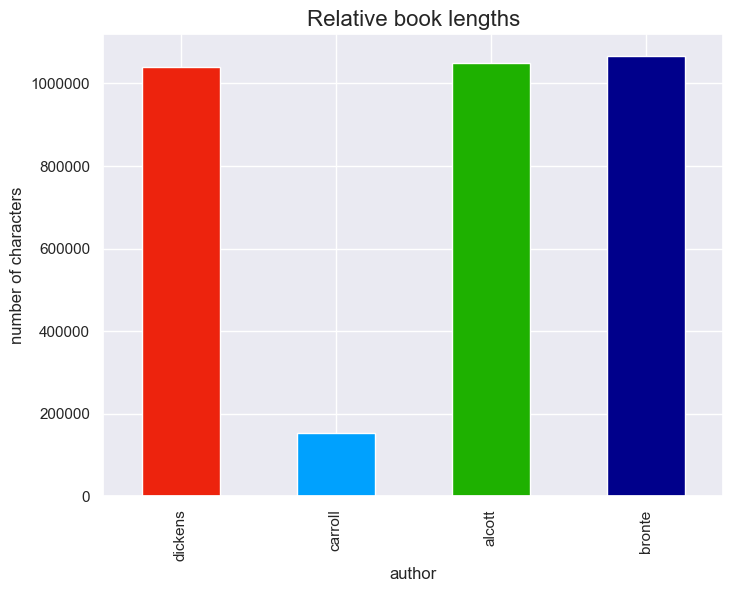

In [50]:
book_lengths = pd.DataFrame.from_dict({key: len(value) for key, value in books.items()}, 
                                      orient = 'index').reset_index()
book_lengths.columns = ['author', 'length']
book_lengths.plot(x = 'author', y = 'length', kind = 'bar', 
                  color = author_colors, legend = False, ylabel = 'number of characters')
plt.title('Relative book lengths', fontsize = 16)
plt.ticklabel_format(style='plain', axis='y')
plt.show()

__Observations__

* Alice in Wonderland is a _very_ much shorter read, which is what we are expecting, given that we know it is primarily aimed at children, where the other 2 books could be for either older children or adults. Of course if we had no prior knowledge of the books we might wonder if `carroll` were a short story. It should in fact be perfectly possible to train a model to classify whether a story is short because it belongs to the short story genre, or because it is aimed at children - but that is the topic of another project!

### 5.2 Chapters in detail

How many chapters does each book have? How long are the chapters? Are the lengths consistent? These are also aspects which can contribute to readability.

#### Number of chapters

In [51]:
# Let's get our chapters into a format ready for analyzing
chapters_df = pd.json_normalize(chapters).transpose().reset_index()
chapters_df.columns = ['reference', 'chapter_text']
chapters_df[['author', 'chapter']] = chapters_df['reference'].str.split('.',expand=True)
chapters_df['length'] = chapters_df['chapter_text'].str.len()
chapters_df.head(2)

,reference,chapter_text,author,chapter,length
0,dickens.0,"My father’s family name being Pirrip, and my Christian name Philip, my infant tongue could make of both names nothing longer or more explicit than Pip. So, I called myself Pip, and came to be called Pip. NEWPARAGRAPH I give Pirrip as my father’s family name, on the authority of his tombstone and my sister,—Mrs. Joe Gargery, who married the blacksmith. As I never saw my father or my mother, and never saw any likeness of either of them (for their days were long before the days of photographs),...",dickens,0,10142
1,dickens.1,"My sister, Mrs. Joe Gargery, was more than twenty years older than I, and had established a great reputation with herself and the neighbours because she had brought me up “by hand.” Having at that time to find out for myself what the expression meant, and knowing her to have a hard and heavy hand, and to be much in the habit of laying it upon her husband as well as upon me, I supposed that Joe Gargery and I were both brought up by hand. NEWPARAGRAPH She was not a good-looking woman, my siste...",dickens,1,19008


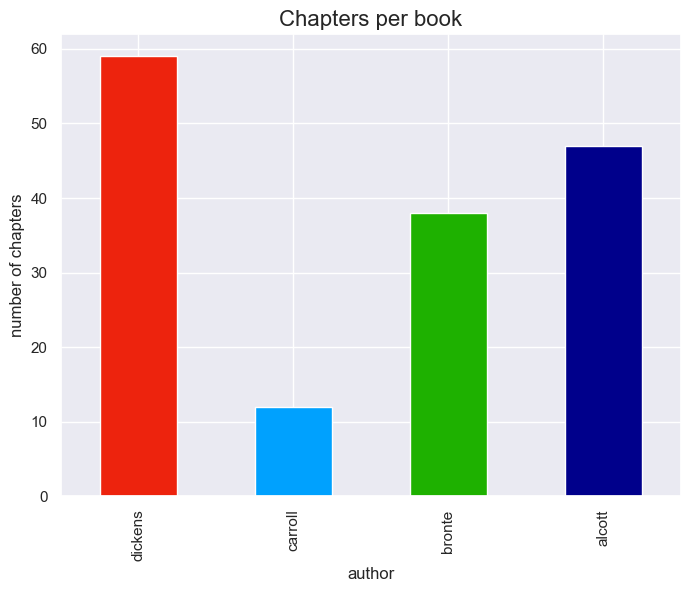

In [52]:
# And now plot the number of chapters per book
num_chapters = chapters_df.groupby(['author']).count().reset_index().sort_values('author', ascending = False)
num_chapters.plot(x = 'author', y = 'chapter', kind = 'bar', color = author_colors, 
                  legend = False, ylabel = 'number of chapters')
plt.title('Chapters per book', fontsize = 16)
plt.ticklabel_format(style='plain', axis='y')
plt.show()

__Observations__

* Remember `alcott` was actually the slightly longer book, but it has fewer chapters compared with `dickens` so we'd expect Little Women's chapters to be overall longer.

#### Chapter lengths

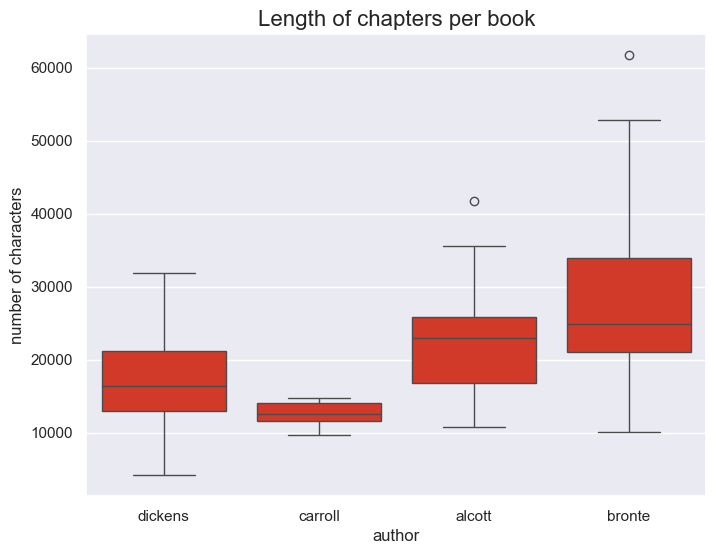

In [53]:
# Let's review chapter lengths per book
sns.set_palette(author_colors) 
box_plot = sns.boxplot(x='author', y='length', data=chapters_df)
box_plot.set(ylabel = 'number of characters')
plt.title('Length of chapters per book', fontsize = 16)
plt.show()

__Observations__

* `alcott` does indeed have the longer chapters overall compared to `dickens` - there's even that one outlier at close to 45000 - but they both vary their chapter lengths quite a bit. `carroll`, as expected, has the shortest chapters of all, and they are more consistent in length.

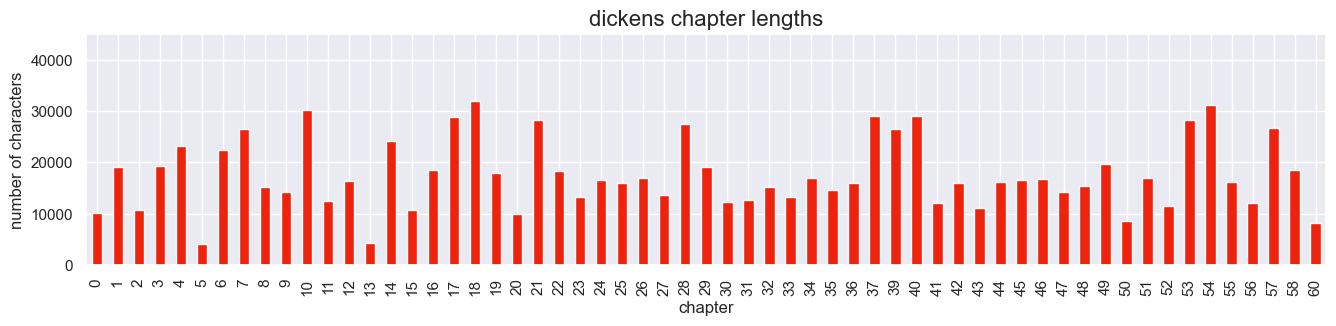

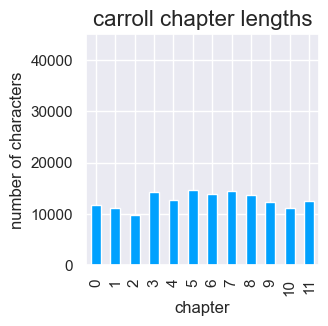

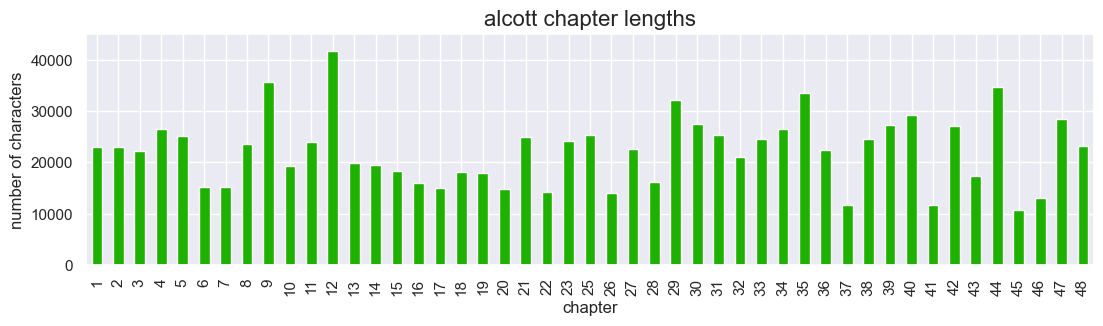

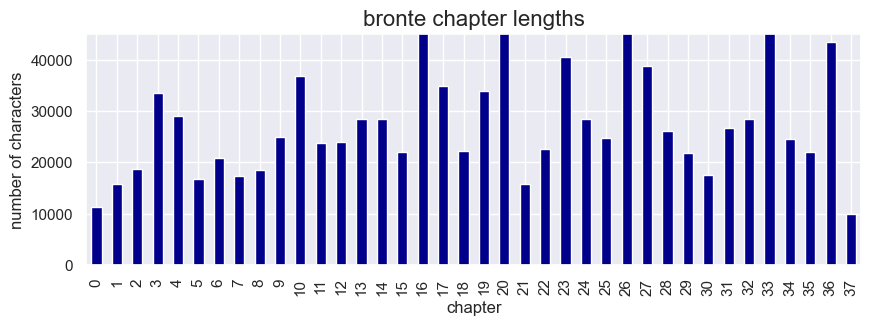

In [54]:
# What is the rhythm of the chapter lengths?
for i, book in enumerate(books.keys()):
    ax = chapters_df.loc[chapters_df['author'] == book, 
                          ['chapter', 'length']].plot(kind = 'bar', x = 'chapter', y = 'length',
                          legend = False, color = author_colors[i],
                          figsize = (int(len(chapters_df.loc[chapters_df['author'] == book, 'length']) / 3.5), 3),
                          ylim = (0, 45000), ylabel = 'number of characters')

    plt.title(book + ' chapter lengths', fontsize = 16)


plt.show()

__Observations:__

* It's interesting to see how variable the chapter lengths are, especially in `dickens` and `alcott`: this could well be part of how the authors create a sense of rhythm in their stories.

### 5.3 Paragraphs in detail

#### Number of paragraphs per chapter

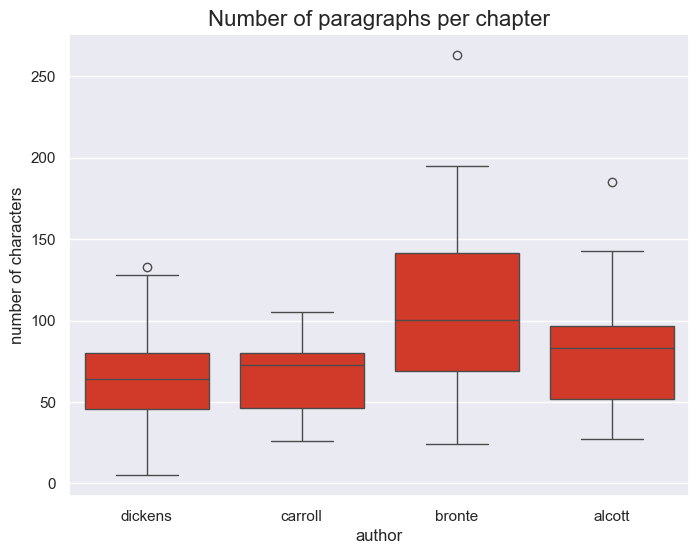

In [55]:
# Let's review number of paragraphs per chapter
num_paragraphs = book_components[['author', 'chapter', 'paragraph']].drop_duplicates()
num_paragraphs = num_paragraphs.groupby(['author', 'chapter']).count().reset_index().sort_values(['author', 'chapter'], ascending = [False, True])
sns.set_palette(author_colors) 
box_plot = sns.boxplot(x='author', y='paragraph', data=num_paragraphs)
box_plot.set(ylabel = 'number of characters')
plt.title('Number of paragraphs per chapter', fontsize = 16)
plt.show()

__Observations__

* They're actually fairly consistent across the 3 authors! 
* There are those 2 outliers (see details below) but when I looked at chapters 17 and 12 respectively, there is nothing especially remarkable about them - they _are_ just longer. 

In [56]:
# The dickens outlier
num_paragraphs.query('author == "dickens"').sort_values('paragraph', ascending = False).head(1)

,author,chapter,paragraph
106,dickens,17,133


In [57]:
# The alcott outlier
num_paragraphs.query('author == "alcott"').sort_values('paragraph', ascending = False).head(1)

,author,chapter,paragraph
3,alcott,12,185


#### Paragraph lengths 

Let's have a look at paragraph lengths per author.

In [58]:
chapter_paragraphs_df = pd.json_normalize(chapter_paragraphs).transpose().reset_index()
chapter_paragraphs_df.columns = ['reference', 'text']
chapter_paragraphs_df[['author', 'chapter', 'paragraph']] = chapter_paragraphs_df['reference'].str.split('.',expand=True)
chapter_paragraphs_df['length'] = chapter_paragraphs_df['text'].str.len()
chapter_paragraphs_df.head(2)

,reference,text,author,chapter,paragraph,length
0,dickens.0.0,"My father’s family name being Pirrip, and my Christian name Philip, my infant tongue could make of both names nothing longer or more explicit than Pip. So, I called myself Pip, and came to be called Pip.",dickens,0,0,203
1,dickens.0.1,"I give Pirrip as my father’s family name, on the authority of his tombstone and my sister, - Mrs. Joe Gargery, who married the blacksmith. As I never saw my father or my mother, and never saw any likeness of either of them (for their days were long before the days of photographs), my first fancies regarding what they were like were unreasonably derived from their tombstones. The shape of the letters on my father’s, gave me an odd idea that he was a square, stout, dark man, with curly black h...",dickens,0,1,1121


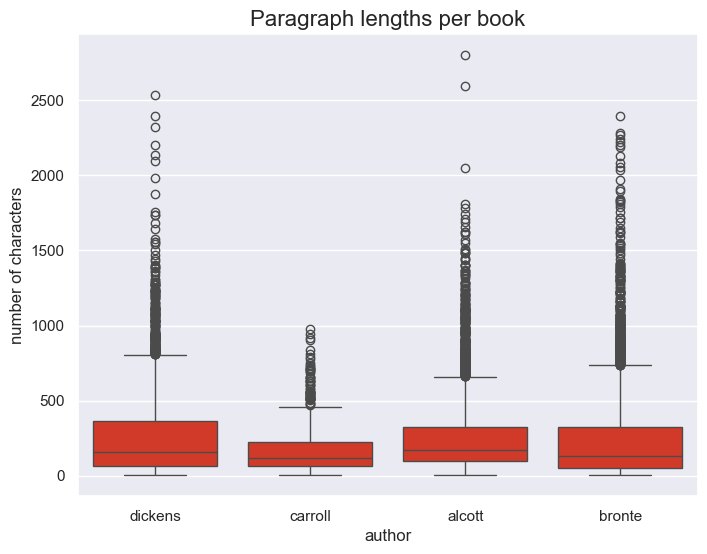

In [59]:
# Let's view paragraph lengths per book
sns.set_palette(author_colors) 
box_plot = sns.boxplot(x='author', y='length', data=chapter_paragraphs_df)
box_plot.set(ylabel = 'number of characters')
plt.title('Paragraph lengths per book', fontsize = 16)
plt.show()

__Observations__

* Quite a few outliers here! Below are some examples from `dickens` - I did a manual cross-check, and these _are_ just very long paragraphs.

In [60]:
# Some dickens outliers
chapter_paragraphs_df.query('author == "dickens"').sort_values('length', ascending = False).head(3)

,reference,text,author,chapter,paragraph,length
2773,dickens.42.31,"“When we was put in the dock, I noticed first of all what a gentleman Compeyson looked, wi’ his curly hair and his black clothes and his white pocket-handkercher, and what a common sort of a wretch I looked. When the prosecution opened and the evidence was put short, aforehand, I noticed how heavy it all bore on me, and how light on him. When the evidence was giv in the box, I noticed how it was always me that had come for’ard, and could be swore to, how it was always me that the money had b...",dickens,42,31,2538
562,dickens.9.1,"The Educational scheme or Course established by Mr. Wopsle’s great-aunt may be resolved into the following synopsis. The pupils ate apples and put straws down one another’s backs, until Mr. Wopsle’s great-aunt collected her energies, and made an indiscriminate totter at them with a birch-rod. After receiving the charge with every mark of derision, the pupils formed in line and buzzingly passed a ragged book from hand to hand. The book had an alphabet in it, some figures and tables, and a lit...",dickens,9,1,2394
3443,dickens.53.76,"Entreating Herbert to tell me how he had come to my rescue, - which at first he had flatly refused to do, but had insisted on my remaining quiet, - I learnt that I had in my hurry dropped the letter, open, in our chambers, where he, coming home to bring with him Startop whom he had met in the street on his way to me, found it, very soon after I was gone. Its tone made him uneasy, and the more so because of the inconsistency between it and the hasty letter I had left for him. His uneasiness i...",dickens,53,76,2321


### 5.4 Sentences in detail

For me, if anything can make a book difficult to read, it's long sentences so I was particularly interested in this part of the analysis.

In [61]:
book_components['sentence_lengths'] = book_components['lemmas'].apply(lambda x: len(x))

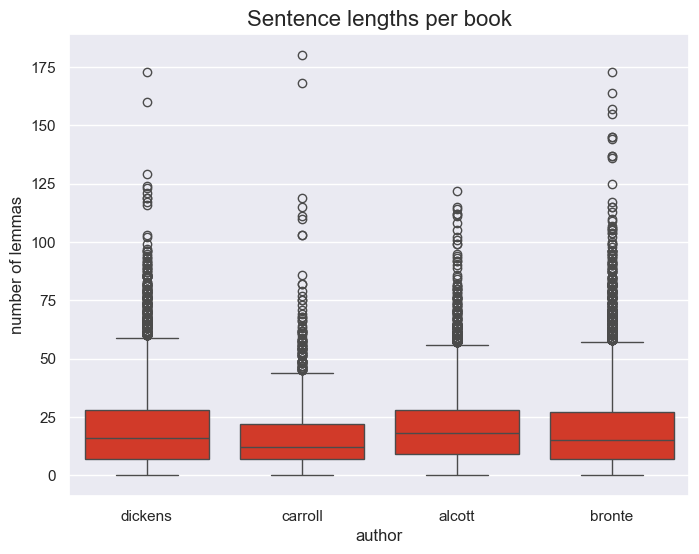

In [62]:
# Let's view sentence lengths per book
sns.set_palette(author_colors) 
box_plot = sns.boxplot(x='author', y='sentence_lengths', data=book_components)
box_plot.set(ylabel = 'number of lemmas')
plt.title('Sentence lengths per book', fontsize = 16)
plt.show()

__Observations__

* As it turns out there's not much between them, although there are those outliers to wonder about! Just for fun, below is the text of the _longest_ sentence from `carroll` which I think is actually a delightful use of a long sentence - it helps reflect the crescendo of the developing game, and phew! we finally got to the end!

In [63]:
pprint.pprint(book_components.sort_values(by = 'sentence_lengths', ascending = False).head(1)['text'][10088])

('Hardly knowing what she did, she picked up a little bit of stick, and held '
 'it out to the puppy; whereupon the puppy jumped into the air off all its '
 'feet at once, with a yelp of delight, and rushed at the stick, and made '
 'believe to worry it; then Alice dodged behind a great thistle, to keep '
 'herself from being run over; and the moment she appeared on the other side, '
 'the puppy made another rush at the stick, and tumbled head over heels in its '
 'hurry to get hold of it; then Alice, thinking it was very like having a game '
 'of play with a cart-horse, and expecting every moment to be trampled under '
 'its feet, ran round the thistle again; then the puppy began a series of '
 'short charges at the stick, running a very little way forwards each time and '
 'a long way back, and barking hoarsely all the while, till at last it sat '
 'down a good way off, panting, with its tongue hanging out of its mouth, and '
 'its great eyes half shut.')


Looking at the number of sentences with no lemmas is also a way to cross-check whether we have done a reasonable job with the data cleaning. There are a handful of sentences that have ended up wordless, but 16 / 20144 sentences is a small number of issues that I can definitely live with: especially in the spirit of 'minimum viable product'.

In [64]:
book_components.query('sentence_lengths == 0')

,author,chapter,paragraph,sentence,text,lemmas,sentence_lengths
2851,dickens,17,90,4,- ”,[],0
4752,dickens,28,68,3,.,[],0
8899,dickens,54,78,3,.,[],0
9700,carroll,0,17,0,*,[],0
9701,carroll,0,17,1,* * * * * *,[],0
9702,carroll,0,18,0,*,[],0
9703,carroll,0,18,1,* * * * *,[],0
9704,carroll,0,19,0,*,[],0
9705,carroll,0,19,1,* * * * * *,[],0
9724,carroll,0,27,0,*,[],0


## 6.5 Vocabulary in detail

Another interesting avenue of investigation is to look at the size of the vocabulary used in each book, as well as how much overlap there is or isn't between the authors.

### 6.5.1 Vocabulary data

In [65]:
# Let's use nltk to get word frequencies per book
all_lemmas = {}
vocabulary_freqs = {}

for book in books.keys():
    all_words = list(itertools.chain.from_iterable(book_components.loc[book_components['author'] == book, 'lemmas']))
    all_lemmas[book] = all_words
    vocabulary_freqs[book] = nltk.FreqDist(all_words)

In [66]:
# And put this into into a dataframe for ease of use later
vocabulary_dfs = {}
for book in books.keys():
    vocabulary_dfs[book] = pd.json_normalize(vocabulary_freqs[book]).transpose().reset_index()
    vocabulary_dfs[book].columns = ['lemma', 'freq']
vocabulary_dfs['alcott'].head()

,lemma,freq
0,christmas,37
1,will,1041
2,not,2593
3,be,5519
4,without,122


In [67]:
# I also want to get vocabulary sets so that we can more easily visualize how much the vocabularies intersect
vocabulary_sets = {}
for book in books.keys():
    vocabulary_sets[book] = set(vocabulary_dfs[book]['lemma'])

#### Vocabulary database

`vocabulary_dfs` are useful artefacts that we may want to use again in future analyses so I'm going to save those to our database at this point.

In [68]:
# Save to the database
for book in books.keys():
    table_name = book + '_vocab'
    vocabulary_dfs[book].to_sql(table_name, engine, schema=None, 
              if_exists='replace', index=True)

In [69]:
# And then check the tables landed safely
%sql SELECT name FROM sqlite_master WHERE type='table' AND name LIKE '%vocab';

 * sqlite:///book_store.db
Done.


name
dickens_vocab
carroll_vocab
alcott_vocab
bronte_vocab


#### Vocabulary size

Now let's have a look at the size of each author's vocabulary - bearing in mind that this is the lemmatized vocabulary so words like __are__, __is__, __am__, etc. will all be reduced to a single word __be__.

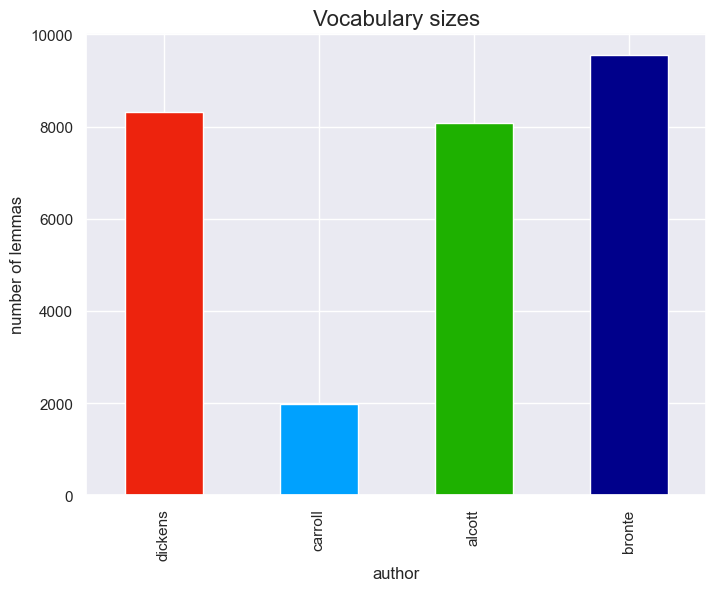

In [70]:
# Get the vocab sizes
vocab_sizes = pd.DataFrame(columns = ['author', 'size'])
for i, book in enumerate(books.keys()):
    vocab_sizes.loc[i] = [book, len(vocabulary_dfs[book])]

# Plot the vocab sizes
vocab_sizes.plot(x = 'author', y = 'size', kind = 'bar', color = author_colors, 
                  legend = False, ylabel = 'number of lemmas', figsize = (8, 6))
plt.title('Vocabulary sizes', fontsize = 16)
plt.ticklabel_format(style='plain', axis='y')
plt.show()

__Observations__

* `dickens` and `alcott` have _huge_ vocabularies compared to `carroll`, which is somewhat expected given the relative lengths of the books.

#### Vocabulary overlap

We would expect that with the 4 authors having different backgrounds and writing styles, there would be a certain amount of 'uniqueness' to each book's vocabularies. Let's have a look at the extent to which the Dickens, Alcott, and Carroll vocabularies overlap.

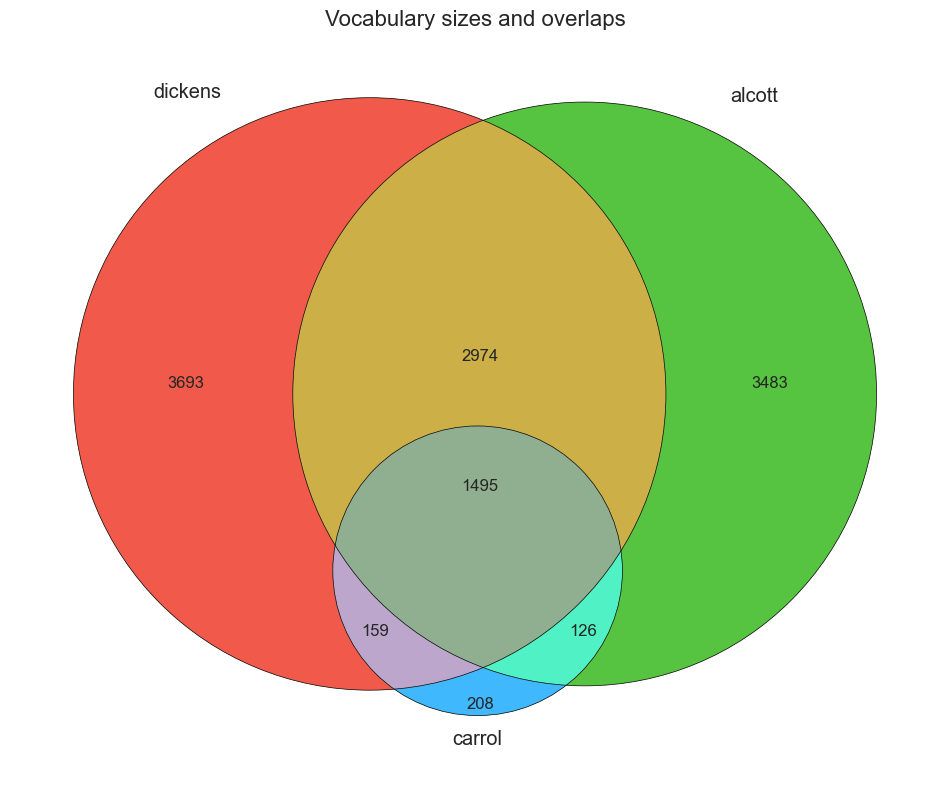

In [71]:
plt.rcParams['figure.figsize'] = (12, 12)
venn3([vocabulary_sets['dickens'], vocabulary_sets['alcott'], vocabulary_sets['carroll']],
      set_colors=('#ED230D', '#1EB100', '#00A1FE'), 
      set_labels = ('dickens', 'alcott', 'carrol'),
      alpha=0.75)
venn3_circles([vocabulary_sets['dickens'], vocabulary_sets['alcott'], vocabulary_sets['carroll']], lw=0.5)
plt.title('Vocabulary sizes and overlaps', fontsize = 16) 
plt.show()

__Observations__

* There are large numbers of words that are unique to individual authors. Fewer with `carroll`, which is expected since Alice in Wonderland already has a smaller vocabulary. But still, it certainly looks like vocabulary is a good indicator of author distinctiveness.

#### Words unique to each author

Let's get a feel for which words are unique to each author. I'll use wordclouds to help us here.

In [72]:
def create_word_cloud(book, freq_dict, colormap):
    cloud = WordCloud(background_color='white', max_words=40, colormap = colormap)
    
    # generate word cloud
    cloud.generate_from_frequencies(freq_dict)

    # show
    plt.imshow(cloud)
    plt.axis('off')
    plt.title(f'''Top 40 lemmas unique to {book}
    ''', fontsize = 16)
    plt.show()

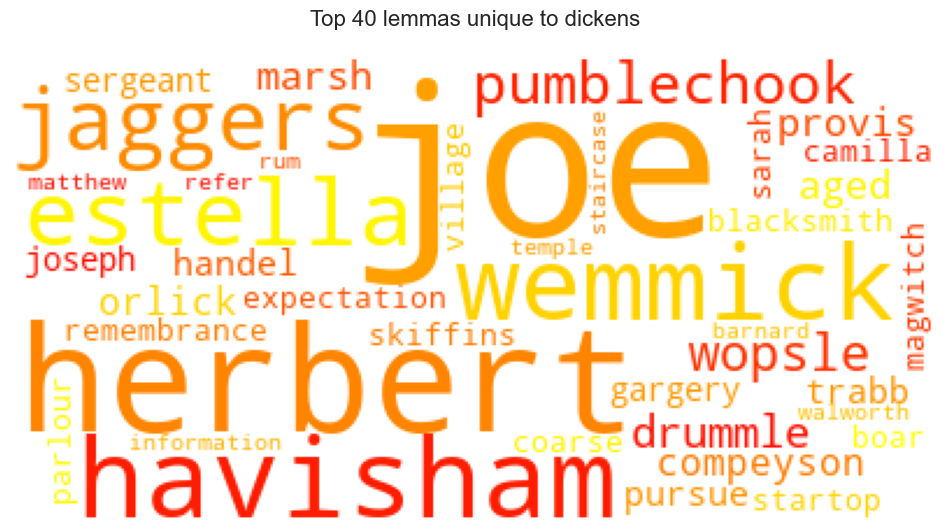

In [73]:
unique_to_dickens = list(vocabulary_sets['dickens'] - vocabulary_sets['carroll'] - vocabulary_sets['alcott'])
dickens_top_40 = vocabulary_dfs['dickens'][vocabulary_dfs['dickens']['lemma'].isin(unique_to_dickens)].sort_values('freq', ascending = False).head(40)
dickens_top_40 = dict(dickens_top_40[['lemma', 'freq']].values)
create_word_cloud('dickens', dickens_top_40, 'autumn')

__Observations__

* We can see that many of the top lemmas that come out are key characters from the book.

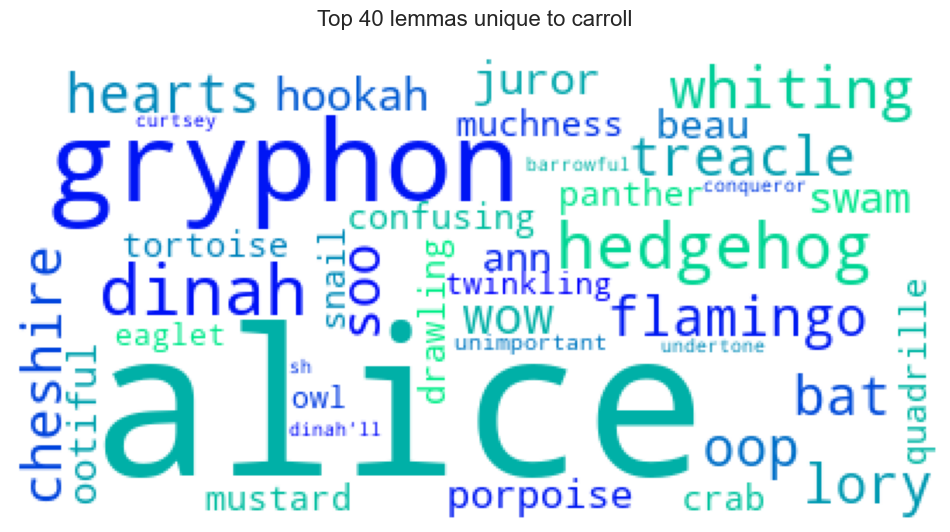

In [74]:
unique_to_carroll = list(vocabulary_sets['carroll'] - vocabulary_sets['dickens'] - vocabulary_sets['alcott'])
carroll_top_40 = vocabulary_dfs['carroll'][vocabulary_dfs['carroll']['lemma'].isin(unique_to_carroll)].sort_values('freq', ascending = False).head(40)
carroll_top_40 = dict(carroll_top_40[['lemma', 'freq']].values)
create_word_cloud('carroll', carroll_top_40, 'winter')

__Observations__

* Again we get key characters like `alice` and `dinah`, but we also get a good selection of words that are indicative of that whimsical, fantasy-style: `twinkling`, `confusing`, `undertone`, as well as `gryphon` and a host of other animals that do not come into the other books that are more grounded in reality.

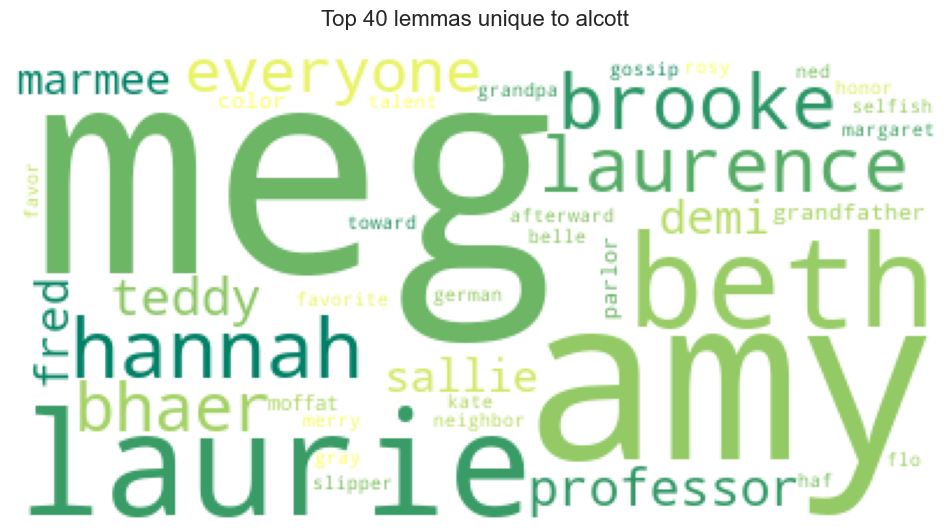

In [75]:
unique_to_alcott = list(vocabulary_sets['alcott'] - vocabulary_sets['dickens'] - vocabulary_sets['carroll'])
alcott_top_40 = vocabulary_dfs['alcott'][vocabulary_dfs['alcott']['lemma'].isin(unique_to_alcott)].sort_values('freq', ascending = False).head(40)
alcott_top_40 = dict(alcott_top_40[['lemma', 'freq']].values)
create_word_cloud('alcott', alcott_top_40, 'summer')

__Observations__

* Character names predominate again, but in amongst these are words indicative of the home life and aspirational aspects of the book: `slipper`, `parlor`, `talent`, `professor`, `honor` and so on.